# Pix2Pix

- Based on: https://arxiv.org/pdf/1611.07004.pdf
- Trained mostly on Google Colab
- datasets from http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/

In [1]:
import os
import time
import torch
import imageio
import torchvision
import ab_transforms as abt
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch import nn
from data_loaders import Facades, Maps, Cityscapes
from architectures import EncoderDecoderGenerator, UNetGenerator, PatchGANDiscriminator
from utils import gen_save_examples, gen_save_model, load_model, gen_get_cond, show_stats, save_model, train

## Architecture

### Generator
There are two generator architectures tested in the paper:
- encoder-decoder
- U-net

U-net differs from encoder-decoder only by additional skip connections from $i$th layer to $(n-i)$th.

#### Key features
- all convolutional (no fully-connected layers)
- encoder has convolutions that downsample by a factor of 2
- decoder has transposed convolutions that upsample by a factor of 2
- filter=4, stride=2
- uses L1 regularization
- *doesn't* use noise as its input, but uses dropout **at both training and test time**
- uses batch statistics at test time instead of aggregated training statistics

### Discriminator

#### Key features
- "PatchGAN" of receptive field N that evaluates all NxN patches of the input
- outputs matrix of probabilities, one for each patch
- end output is an average of that matrix

## Experiment config

In [2]:
# all string values are case insensitive
config = {
   'epochs': 100,
   'batch_size': 1,
   'learning_rate': 0.0002,
   'betas': (0.5, 0.999),
   'lambda': 100,
   'time': time.strftime("%Y-%m-%d_%H-%M", time.localtime()), # just to not overwrite stuff
   'a2b': False, # direction of translation, which images are input and which are output
   'experiment_name': 'noavg_outputs', # used in saved model name
   'dataset': 'facades', # pick a dataset
   'gen_type': 'unet', # possible options: 'unet', 'ed'
   'dis_type': 'patchgan', # possible options: 'patchgan'
   'model_snapshot': {
       'epoch_period': 1, # saves model every this number of epochs
   },
   'std': 1,
   'mean': 0,
   'avg_outputs': False
#    'bnorm_track_stats': True,
   #'explicit_instancenorm': True # replaces nn.BatchNorm2d with nn.InstanceNorm2d
}

## Load the dataset

In [3]:
std, mean = config.get('std', 0.5), config.get('mean', 0.5)
if config['dataset'].lower() == 'facades':
    dataset_train = Facades(root="datasets", folder="train", download=True,
                            transform=abt.Compose([abt.ToTensor(),
                                                   abt.RandomJitter((286,286), (256,256)),
                                                   abt.RandomHorizontalFlip(),
                                                   abt.Normalize(mean, std)]))
    dataset_test = Facades(root="datasets", folder="test", download=False,
                           transform=abt.Compose([abt.ToTensor(), abt.Normalize(mean, std)]))
elif config['dataset'].lower() == 'maps':
    dataset_train = Maps(root="datasets", folder="train", download=True,
                         transform=abt.Compose([abt.ToTensor(),
                                                abt.Resize((256, 256)),
                                                abt.RandomJitter((286,286), (256,256)),
                                                abt.RandomHorizontalFlip(),
                                                abt.Normalize(mean, std)]))
    dataset_test = Maps(root="datasets", folder="val", download=False,
                        transform=abt.Compose([abt.ToTensor(),
                                               abt.Resize((256, 256)),
                                               abt.Normalize(mean, std)]))
elif config['dataset'].lower() == 'cityscapes':
    dataset_train = Cityscapes(root="datasets", folder="train", download=True,
                               transform=abt.Compose([abt.ToTensor(),
                                                      abt.RandomJitter((286,286), (256,256)),
                                                      abt.RandomHorizontalFlip(),
                                                      abt.Normalize(mean, std)]))
    dataset_test = Cityscapes(root="datasets", folder="val", download=False,
                              transform=abt.Compose([abt.ToTensor(),
                                                     abt.Resize((256, 256)),
                                                     abt.Normalize(mean, std)]))
else:
    raise ValueError('Unknown dataset: %s' % config['dataset'])

### Preview

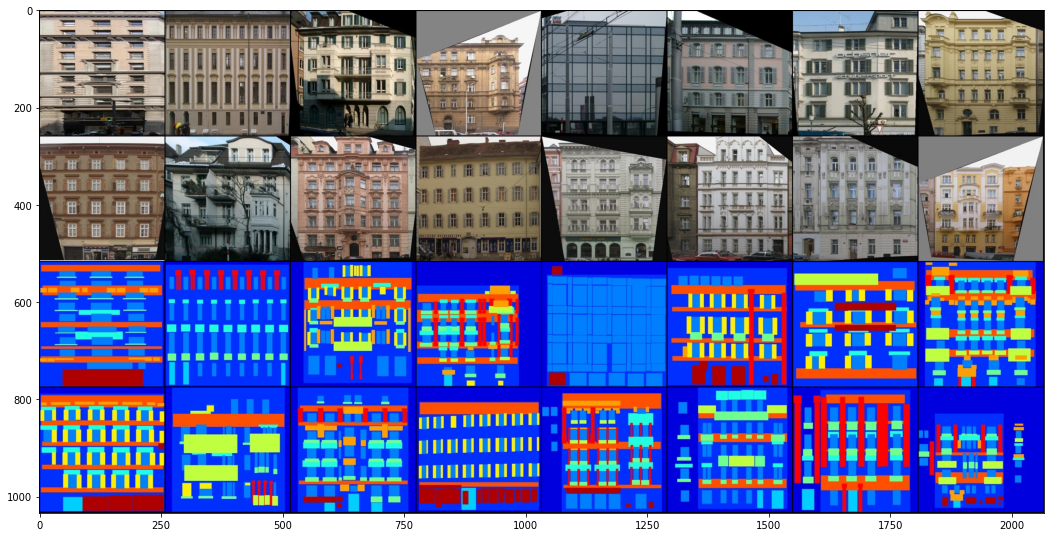

In [4]:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=16, shuffle=True, num_workers=0)
preview_iter = iter(test_loader)
imgA, imgB = preview_iter.next()

fig, ax = plt.subplots(figsize=(18,18))
images = std*torch.cat((imgA, imgB), dim=0) + mean
ax.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))

# save images side by side with their counterpart
# t = []
# for a, b in zip(imgA, imgB):
#     t.append(a)
#     t.append(b)
# combined = 0.5*torch.stack(t)+0.5
# torchvision.utils.save_image(combined.detach(), fp="preview.jpg", nrow=8, padding=0)

try:
    print(dis(imgA.to(DEVICE), imgB.to(DEVICE)).T)
except NameError:
    pass

## Training

In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Device: %s" % torch.cuda.get_device_name(DEVICE))
else:
    print("CUDA not available. Using CPU.")

if config['gen_type'].lower() == "unet":
    gen = UNetGenerator(optim=torch.optim.Adam, lr=config['learning_rate'],
                        betas=config['betas'], lambd=config['lambda'],
                        bnorm_track_stats=config.get('bnorm_track_stats', False),
                        explicit_instancenorm=config.get('explicit_instancenorm', False)).to(DEVICE)
elif config['gen_type'].lower() == "ed":
    gen = EncoderDecoderGenerator(optim=torch.optim.Adam, lr=config['learning_rate'],
                                  betas=config['betas'], lambd=config['lambda'],
                                  bnorm_track_stats=config.get('bnorm_track_stats', False),
                                  explicit_instancenorm=config.get('explicit_instancenorm', False)).to(DEVICE)
else:
    raise ValueError("Unknown generator type: %s" % config['gen_type'])

if config['dis_type'].lower() == "patchgan":
    dis = PatchGANDiscriminator(optim=torch.optim.Adam, criterion=torch.nn.BCELoss(),
                                lr=config['learning_rate'], betas=config['betas'],
                                avg_outputs=config.get('avg_outputs', True)).to(DEVICE)
else:
    raise ValueError("Unknown discriminator type: %s" % config['dis_type'])

try:
    from google.colab import drive
    drive.mount('/content/drive')
    img_path = "drive/MyDrive/images/"
    model_path = "drive/MyDrive/models/"
except ImportError:
    print("Not running on Colab. Skipping drive mount.")
    img_path = "images/"
    model_path = "models/"

dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=config['batch_size'], shuffle=True, num_workers=0, drop_last=True)

Device: Tesla K80
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
EPOCHS = config['epochs']
EPOCH_OFFSET = 0 # only useful when training in parts

fwsconfig = config.get('forward_snapshot', {})
if fwsconfig.get('on', True):
    # periodically generates and saves samples
    fw_snapshot = gen_save_examples(img_path + ("%s_%s_%s" % (config['dataset'], config['experiment_name'], config['time'])), gen,
                                    cond_gen=gen_get_cond(dataset_test, fwsconfig.get('n', 16)),
                                    epoch_offset=EPOCH_OFFSET,
                                    period=fwsconfig.get('period', len(dataloader)),
                                    name_format="{epoch}_{batch}.png",
                                    nrow=8, padding=0, device=DEVICE,
                                    stat=(std,mean), A2B=config['a2b'])
else:
    fw_snapshot = None
    
msconfig = config.get('model_snapshot', {})
if msconfig.get('on', True):
    # periodically saves entire model with optimizer data and stats from training
    model_snapshot = gen_save_model(model_path, gen, dis, config['batch_size'],
                                    period=msconfig.get('period', len(dataloader)),
                                    epochperiod=msconfig.get('epoch_period', 5),
                                    name_format=config['dataset'] + '_' + config['experiment_name'] + ("_A2B" if config['a2b'] else "_B2A") +
                                    "%s_%s_%s__{batch}" % (config['gen_type'], config['dis_type'], config['time']))
else:
    model_snapshot = None
    
stats_tmp = train(gen, dis, dataloader, epochs=EPOCHS,
                  device=DEVICE, A2B=config['a2b'],
                  fw_snapshot=fw_snapshot, model_snapshot=model_snapshot)
# combining stats when training in parts
try:
    if stats:
        stats["gen"]["loss"] = stats["gen"]["loss"] + stats_tmp["gen"]["loss"]
        stats["dis"]["loss"] = stats["dis"]["loss"] + stats_tmp["dis"]["loss"]
        stats["dis"]["prob"] = stats["dis"]["prob"] + stats_tmp["dis"]["prob"]
except NameError:
    stats = stats_tmp

Using device: cuda:0


## Loss plot

In [15]:
show_stats(stats)

<bound method Module.modules of Sequential(
  (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (12): Sigmoid()
)>


## Save model

In [ ]:
try:
    if drive:
        path = "drive/MyDrive/models/"
except NameError:
    print("Drive not mounted.")
    path = "models/"

save_model(path, config['dataset'] + '_' + config['experiment_name'] + ("_A2B" if config['a2b'] else "_B2A") + 
           "_%s_%s_%s" % (config['gen_type'], config['dis_type'], config['time']) + "_%sepochs" % (EPOCHS + EPOCH_OFFSET), config['batch_size'],
           gen, dis, stats, EPOCHS, EPOCH_OFFSET)

In [ ]:
# with imageio.get_writer("images/%s/result_test.gif" % TIME, mode='I', duration=0.1) as writer:
#     for i in range(5):
#         step = i * 5 +  1
#         writer._duration = 0.1 * i + 0.1
#         for filename in ["images/%s/%d_%d.png" % (TIME, i, j) for j in range(0, len(dataloader), step)]:
#             image = imageio.imread(filename)
#             writer.append_data(image)

## Load model

165 1


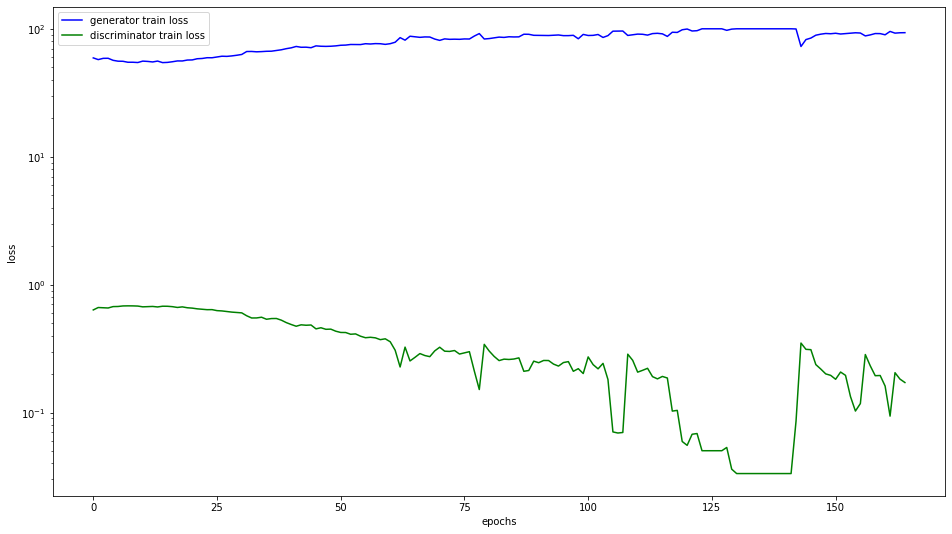

In [ ]:
# CAUTION: don't overwrite trained models
try:
    if drive:
        load_path = "/content/drive/MyDrive/models/maps_nonormB2Aunet_patchgan_2021-01-26_08-56_164epochs"
except NameError:
    print("Drive not mounted.")
    load_path = "models/FILE_NAME_HERE"

# EPOCH_OFFSET is only used if you want to train in parts and not break snapshot numbering
# e.g. 50 epochs now and 50 later, but images in the second wave will be shifted by 50
EPOCH_OFFSET, BATCH_SIZE2, stats = load_model(load_path, gen, dis, device=DEVICE)
print(EPOCH_OFFSET, BATCH_SIZE2)
show_stats(stats)

## Generator preview

In [ ]:
genpreview_loader = torch.utils.data.DataLoader(dataset_test, batch_size=16, shuffle=True, num_workers=0)
genpreview_iter = iter(genpreview_loader)
imgA, imgB = genpreview_iter.next()
imgA, imgB = imgA.to(DEVICE), imgB.to(DEVICE)
gen.eval()
dis.eval()
real, cond = (imgB, imgA) if config['a2b'] else (imgA, imgB)
examples = gen(cond)

fig, ax = plt.subplots(figsize=(32,32))
combined = std*torch.cat((examples.detach(), real, cond), dim=0) + mean
ax.imshow(torchvision.utils.make_grid(combined.cpu()).cpu().numpy().transpose(1,2,0))

try:
    print(dis(examples, masks).T)
except NameError:
    pass

## Comparison
Loads two models and runs them on the same input

200 1


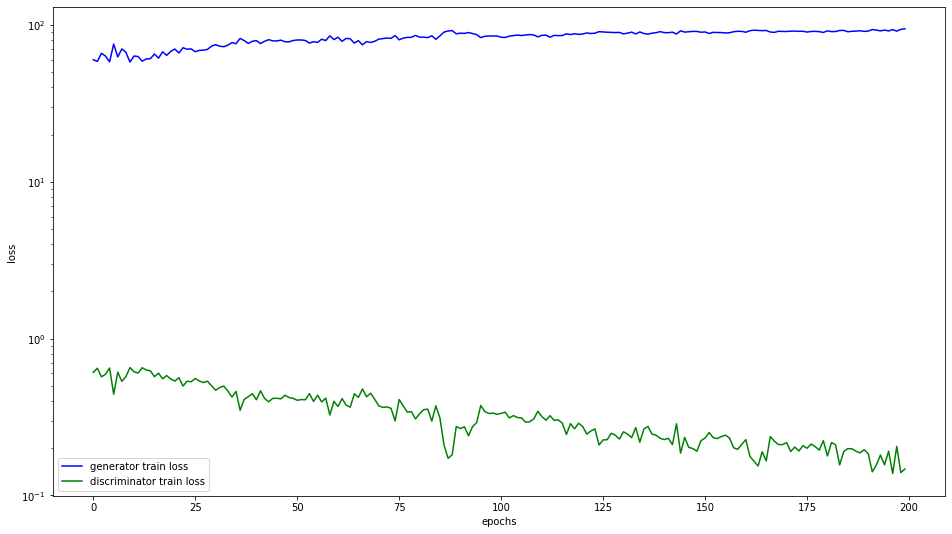

200 1


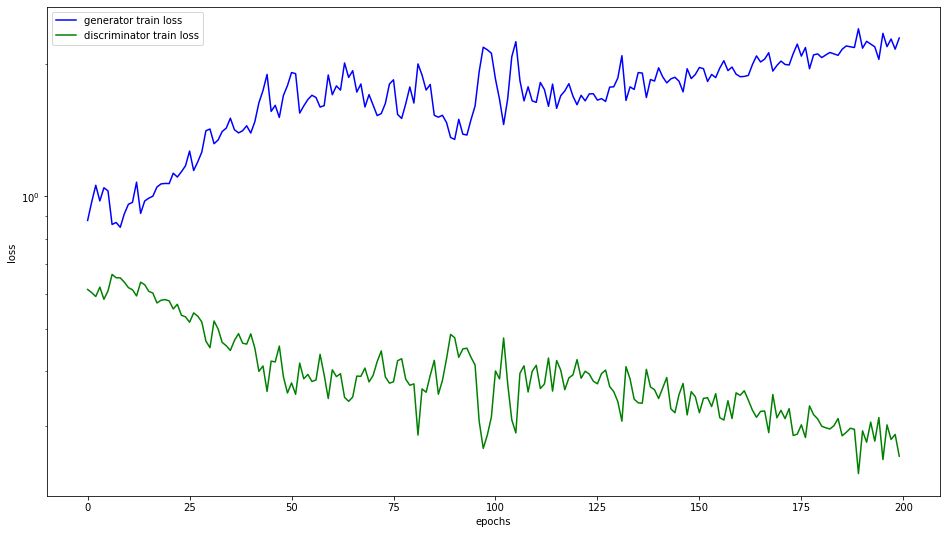

In [ ]:
try:
    if drive:
        first_model = "drive/MyDrive/models/facadesB2A_unet_patchgan_2021-01-22_12-17_200epochs"
        second_model = "drive/MyDrive/models/facadesB2A_unet_patchgan_noL1_2021-01-23_18-14_200epochs"
except NameError:
    print("Drive not mounted.")
    first_model = "models/NAME_HERE"
    second_model = "models/FILENAME_HERE"

first_gen = UNetGenerator(optim=torch.optim.Adam, lambd=100).to(DEVICE)
second_gen = UNetGenerator(optim=torch.optim.Adam, lambd=100).to(DEVICE)
first_dis = PatchGANDiscriminator(optim=torch.optim.Adam, criterion=torch.nn.BCELoss()).to(DEVICE)
second_dis = PatchGANDiscriminator(optim=torch.optim.Adam, criterion=torch.nn.BCELoss()).to(DEVICE)

FIRST_EPOCHS, FIRST_BS, first_stats = load_model(first_model, first_gen, first_dis, device=DEVICE)
print(FIRST_EPOCHS, FIRST_BS)
show_stats(first_stats)

SECOND_EPOCHS, SECOND_BS, second_stats = load_model(second_model, second_gen, second_dis, device=DEVICE)
print(SECOND_EPOCHS, SECOND_BS)
show_stats(second_stats)

comp_loader = torch.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=True, num_workers=0)
comp_iter = iter(comp_loader)

dis1, ex1: tensor([[0.5599, 0.3881, 0.3621, 0.2973, 0.1865, 0.4344, 0.5482, 0.2577]],
       grad_fn=<PermuteBackward>)
dis1, ex2: tensor([[0.2700, 0.3846, 0.3155, 0.4996, 0.3238, 0.3481, 0.4352, 0.3390]],
       grad_fn=<PermuteBackward>)
dis2, ex1: tensor([[0.2479, 0.3587, 0.3507, 0.1633, 0.2343, 0.2053, 0.2522, 0.2207]],
       grad_fn=<PermuteBackward>)
dis2, ex2: tensor([[0.1400, 0.1815, 0.1478, 0.2071, 0.0963, 0.1696, 0.1620, 0.2527]],
       grad_fn=<PermuteBackward>)


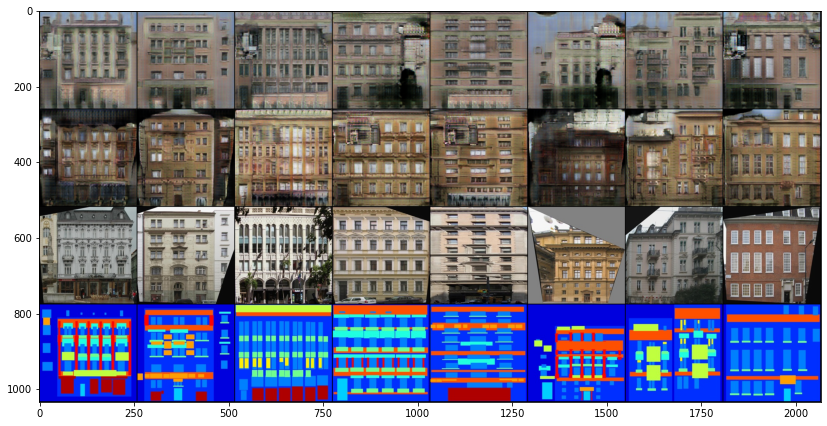

In [ ]:
imgA, imgB = comp_iter.next()
imgA, imgB = imgA.to(DEVICE), imgB.to(DEVICE)
first_gen.eval()
first_dis.eval()
second_gen.eval()
second_dis.eval()

real, cond = imgA, imgB # fill in according to loaded models
first_ex = first_gen(cond)
second_ex = second_gen(cond)

comp_path = "drive/MyDrive/images/test/facades_b2a_unet_l1vsnol1"

if not os.path.isdir(comp_path):
    os.mkdir(comp_path)
fig, ax = plt.subplots(figsize=(14,14))
combined = std*torch.cat((first_ex.detach(), second_ex.detach(), real, cond), dim=0) + mean
ax.imshow(torchvision.utils.make_grid(combined.cpu()).cpu().numpy().transpose(1,2,0), cmap="gray")
fullpath = os.path.join(comp_path, time.strftime("%Y-%m-%d_%H-%M-%S.png", time.localtime()))
torchvision.utils.save_image(combined.detach(), fp=fullpath, nrow=8, padding=0)

try:
    print("dis1, ex1: %s" % first_dis(first_ex, cond).T)
    print("dis1, ex2: %s" % first_dis(second_ex, cond).T)
    print("dis2, ex1: %s" % second_dis(first_ex, cond).T)
    print("dis2, ex2: %s" % second_dis(second_ex, cond).T)
except NameError:
    pass